In [22]:
include("../lna.jl")
include("../functions.jl")

log_likelihood_whole_cell (generic function with 1 method)

In [2]:
N_genes = 10
rn = generate_rn(N_genes)

ps = [N_genes*100., 0.5] # [ribosome production, ribosome degredation]
for j in 1:N_genes
    ps = vcat(
        ps, 
        [
            3, # mRNA creation
            0.7, # mRNA degredation
            1.0, # binding to polysome
            0.1, # unbinding from polysome
            10.0, # translation,
            0.5, # monosome decay
            0.5 # protein decay
        ]
    )
end

prob = LNAProblem(rn, zeros(length(species(rn))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 100000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=100.0)

rib_counts = map(x -> x[1], sol.u)
mrna_counts = map(x -> x[2], sol.u)
rib_int_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
rib_bound_counts = map(x -> sum(x[3+3:3:length(x)]), sol.u);

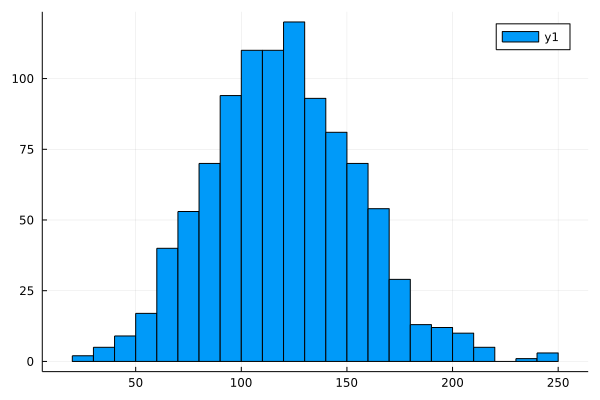

In [3]:
histogram(protein_counts)

Given the protein count data, we aim to infer parameters for each model. We will then compute the bayesian information criterion for each model and compare them.

The first model will be the canonical model.

In [4]:
lower = [0., 0., 0., 0.]
upper = [100, 100, 100, 100]

x = optimize(
    x -> log_likelihood_can(
        protein_counts,
        x[1],
        x[2] + x[4], # ensure k2 > k6
        x[3],
        x[4]
    ), 
    lower, 
    upper, 
    [10., 10., 10., 10.]
)

In [5]:
can_params = Optim.minimizer(x)

can_params = [can_params[1], can_params[2] + can_params[4], can_params[3], can_params[4]]

4-element Vector{Float64}:
 22.949171602513427
  6.011358103331903
 78.70277082085181
  2.511640615039112

In [6]:
can_predicted_mean = can_params[1]*can_params[3]/can_params[2]/can_params[4]
can_predicted_var = can_params[1]*can_params[3]/(can_params[2]*can_params[4]) * (1 + can_params[3]/(can_params[2] + can_params[4]))

1224.2759690345372

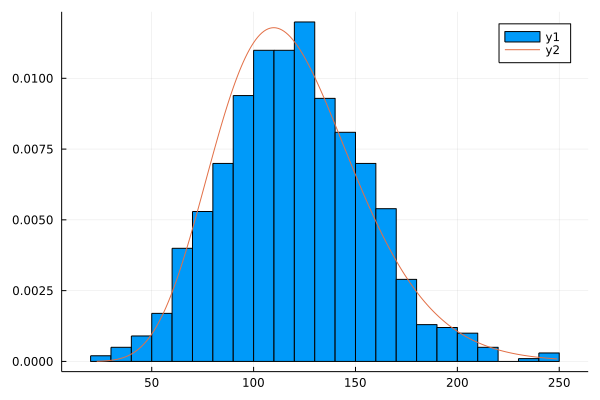

In [7]:
xs = minimum(protein_counts):1:maximum(protein_counts)
histogram(protein_counts, norm=true)
plot!(xs, negative_binomial_ys(xs, can_predicted_mean, can_predicted_var))

In [8]:
BIC_can = 4*log(length(protein_counts)) + 2*log_likelihood_can(protein_counts, can_params...)

9985.564985352998

In [9]:
log_likelihood_can(protein_counts, can_params...)

4978.9649831178685

In [10]:
rn_rib_bound_f()

Model ##ReactionSystem#293 with 9 equations
States (4):
  r(t)
  m(t)
  p(t)
  rb(t)
Parameters (9):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

Next for the bound model. This model has 9 parameters, but some are replicated.

In [11]:
lower = [0., 0., 0., 0., 0., 0., 0.]
upper = [100, 100, 100, 100, 100, 100, 100]

x = optimize(
    x -> log_likelihood_rib_bound(
        protein_counts,
        x[1],
        x[2],
        x[3],
        x[2] + x[4],
        x[5],
        x[2],
        x[6],
        x[7],
        x[2]
    ), 
    lower, 
    upper, 
    [10., 10., 10., 10., 10., 10., 10.]
)

In [12]:
bound_params = Optim.minimizer(x)

bound_params = [
    bound_params[1], 
    bound_params[2], 
    bound_params[3], 
    bound_params[2] + bound_params[4], 
    bound_params[5], 
    bound_params[2],
    bound_params[6],
    bound_params[7],
    bound_params[2]
]

9-element Vector{Float64}:
 58.44966971210678
  3.2650985762380014
 64.04967971173987
 60.170533505850806
 42.75572695665341
  3.2650985762380014
 55.13134254275105
 47.50588470005784
  3.2650985762380014

In [13]:
rn_bound = rn_rib_bound_f()
prob = LNAProblem(rn_bound, zeros(length(species(rn_bound))), bound_params)
sol = solve(prob)
lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

4×4 Matrix{Float64}:
  8.58214      0.0        29.6065   7.99361e-15
  0.0          1.06447     6.1573   0.0
 29.6065       6.1573   1224.28    30.2066
  7.99361e-15  0.0        30.2066   9.3192

In [14]:
bound_predicted_mean = lnameans[3]
bound_predicted_cov = lnacovs[3,3]

1224.2759880875549

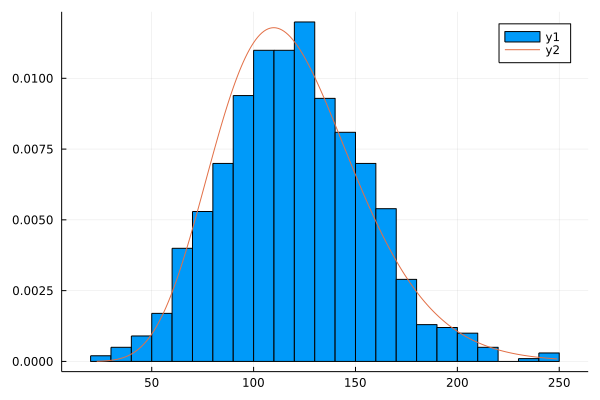

In [15]:
xs = minimum(protein_counts):1:maximum(protein_counts)
histogram(protein_counts, norm=true)
plot!(xs, negative_binomial_ys(xs, bound_predicted_mean, bound_predicted_cov))

In [16]:
log_likelihood_rib_bound(protein_counts, bound_params...)

4978.964983117878

In [17]:
BIC_bound = 7*log(length(protein_counts)) + 2*log_likelihood_rib_bound(protein_counts, bound_params...)

10006.291249690961

Now for the bound int model.

In [23]:
rn_rib_bound_int_f()

Model ##ReactionSystem#308 with 12 equations
States (5):
  r(t)
  m(t)
  rs(t)
  p(t)
  rb(t)
Parameters (12):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [24]:
lower = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
upper = [100, 100, 100, 100, 100, 100, 100, 100, 100]

x = optimize(
    x -> log_likelihood_rib_bound_int(
        protein_counts,
        x[1],
        x[2],
        x[3],
        x[2] + x[4],
        x[5],
        x[6],
        x[7],
        x[2],
        x[2],
        x[8],
        x[9],
        x[2]
    ), 
    lower, 
    upper, 
    [10., 10., 10., 10., 10., 10., 10., 10., 10.]
)
can_params = Optim.minimizer(x);

In [29]:
bound_int_params = Optim.minimizer(x)

bound_int_params = [
    bound_int_params[1], 
    bound_int_params[2], 
    bound_int_params[3], 
    bound_int_params[2] + bound_int_params[4], 
    bound_int_params[5], 
    bound_int_params[6],
    bound_int_params[7],
    bound_int_params[2],
    bound_int_params[2],
    bound_int_params[8],
    bound_int_params[9],
    bound_int_params[2]
]

12-element Vector{Float64}:
 62.84432156299327
  1.8670410745096668
 17.895883367252658
 34.809863109477966
 61.98367007070776
 42.01618607565571
 71.51075700729935
  1.8670410745096668
  1.8670410745096668
 45.59156835782498
 53.71973145176404
  1.8670410745096668

In [30]:
rn_rib_bound_int_f()

Model ##ReactionSystem#308 with 12 equations
States (5):
  r(t)
  m(t)
  rs(t)
  p(t)
  rb(t)
Parameters (12):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [35]:
rn_bound_int = rn_rib_bound_int_f()
prob = LNAProblem(rn_bound_int, zeros(length(species(rn_bound_int))), bound_int_params)
sol = solve(prob)
lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

bound_int_predicted_mean = lnameans[4]
bound_int_predicted_cov = lnacovs[4,4]

1224.275994053353

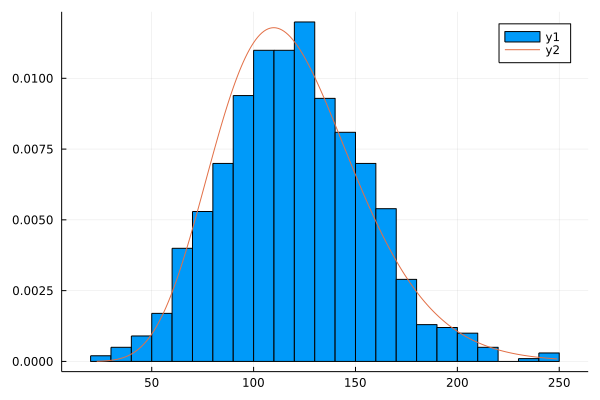

In [36]:
xs = minimum(protein_counts):1:maximum(protein_counts)
histogram(protein_counts, norm=true)
plot!(xs, negative_binomial_ys(xs, bound_int_predicted_mean, bound_int_predicted_cov))

In [37]:
log_likelihood_rib_bound_int(protein_counts, bound_int_params...)

4978.964983117867

In [38]:
BIC_bound = 9*log(length(protein_counts)) + 2*log_likelihood_rib_bound_int(protein_counts, bound_int_params...)

10020.10875924957